<a href="https://colab.research.google.com/github/MSR1805200/projeto_cultivo_dano/blob/master/cultivo_dano_organizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJETO: Predição de dano em cultivos(Versão Final)
----

## 1. COLETA DE DADOS

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


df = pd.read_csv('https://raw.githubusercontent.com/MSR1805200/projeto_cultivo_dano/master/datasets/treino.csv')

#sns.set(rc={'figure.figsize':(9,9)})


In [ ]:
df=df.drop(['ID'],axis=1)

In [ ]:
df['Crop_Damage'] = df['Crop_Damage'].apply(lambda x : 1 if x==2 else x)

In [ ]:
df['Crop_Damage'].value_counts()

0    74238
1    14620
Name: Crop_Damage, dtype: int64

## 2. Lidando com dados *Missing*

In [ ]:
df.isnull().sum()

Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

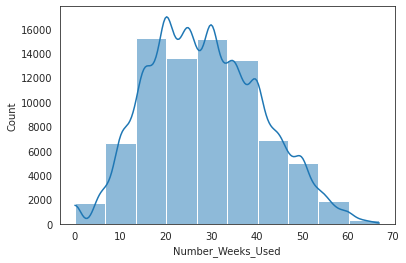

In [ ]:
sns.set_style("white")
sns.histplot(data = df, x = 'Number_Weeks_Used', bins =10, kde = True)

In [ ]:
df['Number_Weeks_Used'] = df['Number_Weeks_Used'].fillna(df['Number_Weeks_Used'].mean())

In [ ]:
df.isnull().sum()

Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64

In [ ]:
df_sem_dados_missing = df[df['Crop_Damage'].notnull()]

In [ ]:
df_sem_dados_missing.isnull().sum()

Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64


## 3. Divisão dos dados

In [ ]:
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(df_sem_dados_missing,test_size = 0.3, stratify = df_sem_dados_missing['Crop_Damage'], shuffle = True, random_state = 42)



## 4. Análise Exploratória


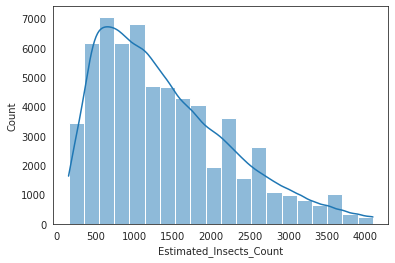

In [ ]:
sns.histplot(data = train_set, x = "Estimated_Insects_Count", bins = 20, kde = True)

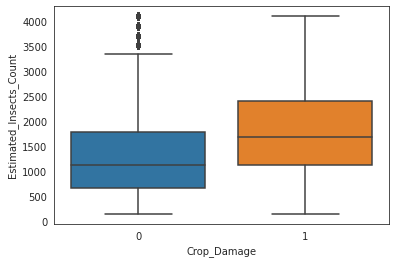

In [ ]:
sns.boxplot(x="Crop_Damage",y = "Estimated_Insects_Count", data=train_set)

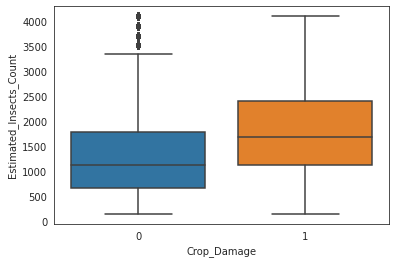

In [ ]:
sns.boxplot(x="Crop_Damage",y = "Estimated_Insects_Count", data=train_set)

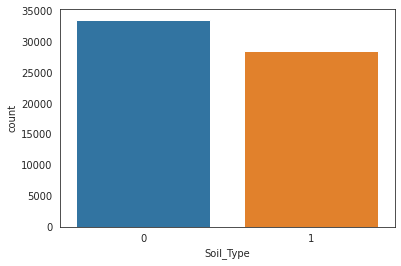

In [ ]:
sns.countplot(x="Soil_Type", data= train_set)

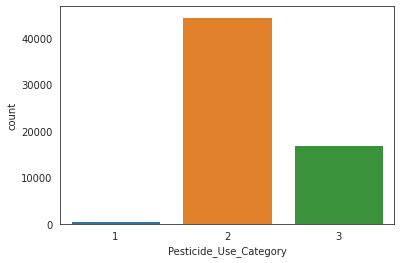

In [ ]:
sns.countplot(x="Pesticide_Use_Category", data= train_set)

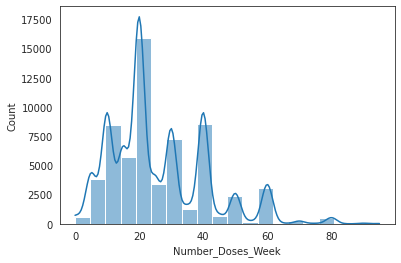

In [ ]:
sns.histplot(data=train_set, x="Number_Doses_Week",kde=True,bins = 20)

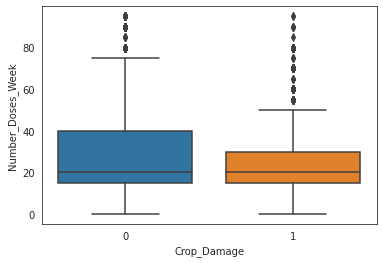

In [ ]:
sns.boxplot(x="Crop_Damage",y = "Number_Doses_Week", data=train_set)

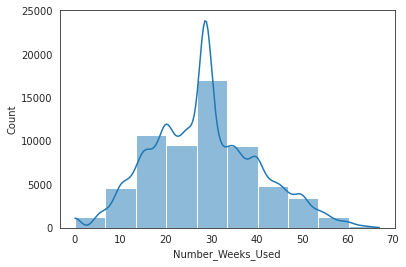

In [ ]:
sns.histplot(data=train_set, x="Number_Weeks_Used",kde=True,bins = 10)

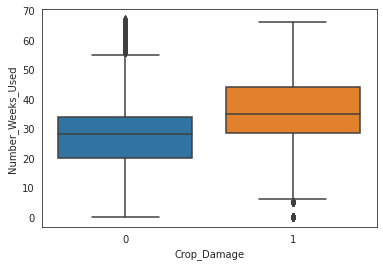

In [ ]:
sns.boxplot(x="Crop_Damage",y ="Number_Weeks_Used", data=train_set)

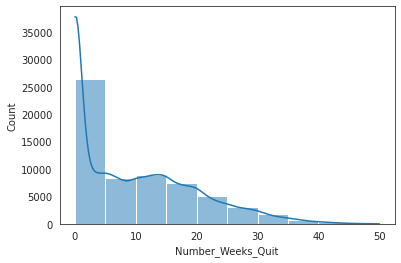

In [ ]:
sns.histplot(data=train_set, x="Number_Weeks_Quit",kde=True,bins = 10)

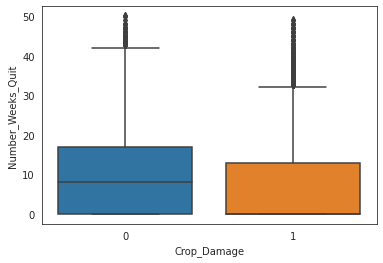

In [ ]:
sns.boxplot(x="Crop_Damage",y ="Number_Weeks_Quit", data=train_set)

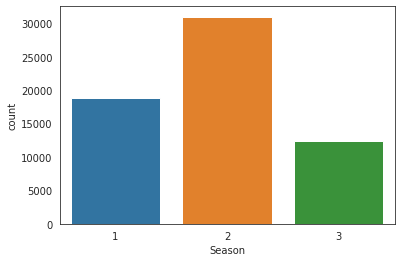

In [ ]:
sns.countplot(data = train_set, x ='Season')

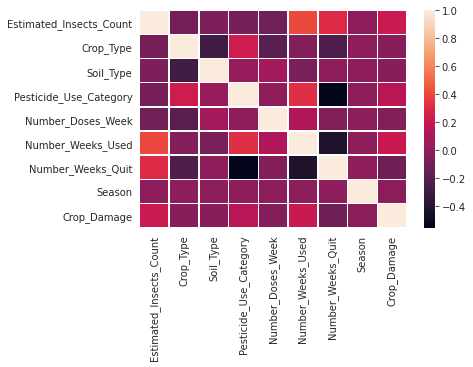

In [ ]:
corr_matriz = train_set.corr()

sns.heatmap(corr_matriz, linewidths=.5)

## 5. Treinamento do lightgbm com o Boruta


In [ ]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.model_selection import cross_val_predict

scale = StandardScaler()

x_treino_com_boruta = train_set.drop(['Crop_Damage'], axis = 1).copy()
y_treino_com_boruta = train_set['Crop_Damage'].copy()


x_teste_com_boruta = test_set.drop(['Crop_Damage'], axis = 1).copy()

y_teste_com_boruta = test_set['Crop_Damage'].copy()


In [ ]:
!pip install lightgbm
!pip install scikit-plot
!pip install Boruta
!pip install shap
!pip install scikit-optimize

     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 356 kB 15.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491654 sha256=caecf339bff752fc3e10e9fcb8d21ed5276ac09950e770f1a4509a36641d0659
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 101 kB 6.0 MB/s 


In [ ]:
import lightgbm as lgb
import scikitplot as skplt
from boruta import BorutaPy
import shap
import skopt


In [ ]:
from sklearn.utils import check_random_state
class BorutaPyForLGB(BorutaPy):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        super().__init__(estimator, n_estimators, perc, alpha,
                         two_step, max_iter, random_state, verbose)
        if random_state is None:
            self.random_state_input = np.random.randint(0, 2**64-1)
        elif isinstance(random_state, int):
            self.random_state_input = random_state
        else:
            raise TypeError('random_state must be int or None')

    def _get_tree_num(self, n_feat):
        depth = self.estimator.get_params()['max_depth']
        if (depth == None) or (depth <= 0):
            depth = 10
        f_repr = 100
        multi = ((n_feat * 2) / (np.sqrt(n_feat * 2) * depth))
        n_estimators = int(multi * f_repr)
        return n_estimators

    def _fit(self, X, y):
        # check input params
        self._check_params(X, y)
        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=np.int)
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=np.int)
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=np.float)
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            self.estimator.set_params(random_state=self.random_state_input)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=np.bool)
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=np.bool)
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=np.int)
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
                # calculate ranks in each iteration, then median of ranks across feats
                iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
                rank_medians = np.nanmedian(iter_ranks, axis=0)
                ranks = self._nanrankdata(rank_medians, axis=0)

                # set smallest rank to 3 if there are tentative feats
                if tentative.shape[0] > 0:
                    ranks = ranks - np.min(ranks) + 3
                else:
                    # and 2 otherwise
                    ranks = ranks - np.min(ranks) + 2
                self.ranking_[not_selected] = ranks
        else:
            # all are selected, thus we set feature supports to True
            self.support_ = np.ones(n_feat, dtype=np.bool)

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self

### 5.1 Seleção de caracteristicas


In [ ]:
y_treino_com_boruta = y_treino_com_boruta.ravel()

clf = lgb.LGBMClassifier(num_boost_round = 100)

seletor_caracteristica = BorutaPyForLGB(clf, n_estimators='auto', verbose=0, random_state=42)

seletor_caracteristica.fit(x_treino_com_boruta.values,y_treino_com_boruta)

x_treino_com_boruta_filtrado = seletor_caracteristica.transform(x_treino_com_boruta.values)

Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument


In [ ]:
y_teste_com_boruta = y_teste_com_boruta.ravel()

x_teste_com_boruta_filtrado = seletor_caracteristica.transform(x_teste_com_boruta.values)

x_teste_com_boruta_filtrado

array([[2401.,   20.,   47.],
       [1575.,   15.,   10.],
       [ 625.,   20.,   33.],
       ...,
       [ 150.,   15.,   18.],
       [ 677.,   20.,   37.],
       [1785.,   45.,   49.]])

In [ ]:
x_treino_com_boruta_filtrado_escalonado = scale.fit_transform(x_treino_com_boruta_filtrado)
x_teste_com_boruta_filtrado_escalonado = scale.transform(x_teste_com_boruta_filtrado)

In [ ]:
y_pred = cross_val_predict(clf, x_treino_com_boruta_filtrado_escalonado,y_treino_com_boruta,cv=10)

print(classification_report(y_treino_com_boruta,y_pred))


Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument


              precision    recall  f1-score   support

           0       0.85      0.99      0.91     51966
           1       0.66      0.09      0.15     10234

    accuracy                           0.84     62200
   macro avg       0.75      0.54      0.53     62200
weighted avg       0.82      0.84      0.79     62200



### 5. 2 Aprimoramento do LightGBM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

params = {
          'importance_type':['gain','split'], 
          'learning_rate':[0.5, 0.1, 0.01],
          'max_depth':[-1, 0, 1, 2],
          'min_child_samples':[20, 30, 40], 
          'min_child_weight':[0.001, 0.01, 0.1], 
          'min_split_gain':[0, 1, 2], 
          'n_estimators':[50, 100, 150], 
          'num_leaves':[31, 41, 51],
          'objective':[None, 'binary'],
          'reg_alpha':[0,0.1,0.001], 
          'reg_lambda':[0,0.1,0.001], 
          'silent':[True],
          'subsample_for_bin':[200000,100000,50000], 
          'subsample_freq':[0,1]   
}

bayes_search = BayesSearchCV(lgb.LGBMClassifier(),n_jobs = -1,search_spaces= params, cv = 10) 

bayes_search.fit(x_treino_com_boruta_filtrado_escalonado,y_treino_com_boruta)


BayesSearchCV(cv=10, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_jobs=-1, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, sile...
                             'learning_rate': [0.5, 0.1, 0.01],
                             'max_depth': [-1, 0, 1, 2],
                             'min_child_samples': [20, 30, 40],
                             'min_child_weight': [0.001, 0.01, 0.1],
         

In [ ]:
melhor_modelo_com_boruta =bayes_search.best_estimator_

### 5.3 Teste

In [ ]:
melhor_modelo_com_boruta.fit(x_treino_com_boruta_filtrado_escalonado,y_treino_com_boruta)

y_pred = melhor_modelo_com_boruta.predict(x_teste_com_boruta_filtrado_escalonado)

print(classification_report(y_teste_com_boruta,y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     22272
           1       0.73      0.07      0.13      4386

    accuracy                           0.84     26658
   macro avg       0.79      0.53      0.52     26658
weighted avg       0.83      0.84      0.78     26658



 Shapley value para dados de **TESTE** com o boruta


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


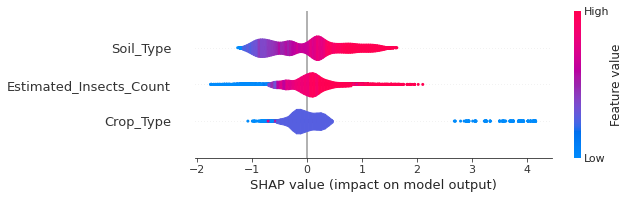

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(melhor_modelo_com_boruta)

shap_values = explainer.shap_values(x_teste_com_boruta_filtrado_escalonado)

shap.summary_plot(shap_values[1], features=x_teste_com_boruta_filtrado_escalonado, feature_names=x_teste_com_boruta.columns, plot_type="violin", show=False, max_display=5)


 ROC Curve para dados de **TESTE** com o boruta

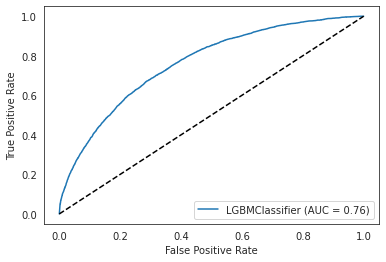

In [ ]:
from sklearn.metrics import plot_roc_curve

roc = plot_roc_curve(melhor_modelo_com_boruta,x_teste_com_boruta_filtrado_escalonado,y_teste_com_boruta)
plt.plot([0, 1], [0, 1], linestyle = '--',color = 'black')
plt.show()

 Precicion Recall Curve para dados de **TESTE** com o boruta

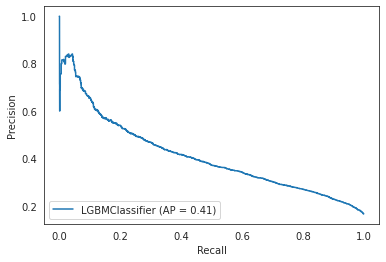

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

curve = plot_precision_recall_curve(melhor_modelo_com_boruta,x_teste_com_boruta_filtrado_escalonado,y_teste_com_boruta)
plt.show()

Curva de calibração para dados de **TESTE** com o boruta

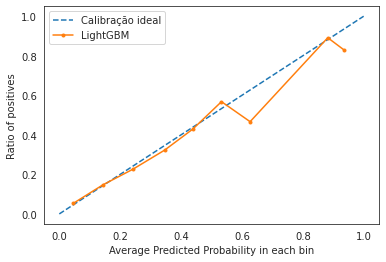

In [ ]:
from sklearn.calibration import calibration_curve

y_prob = melhor_modelo_com_boruta.predict_proba(x_teste_com_boruta_filtrado_escalonado)

x, y = calibration_curve(y_teste_com_boruta, y_prob[:, 1], n_bins = 10, normalize = True)
  
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Calibração ideal')
  
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'LightGBM')
  
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

Curva de Densidade para dados de **TESTE** com o boruta

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


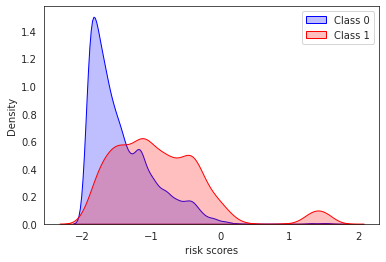

In [ ]:
import seaborn as sns

def remap(old_val, old_min, old_max, new_min, new_max):
    return (new_max - new_min)*(old_val - old_min) / (old_max - old_min) + new_min


sns.set_style("white")

model= melhor_modelo_com_boruta

y_pred_pos = model.predict_proba(x_teste_com_boruta_filtrado_escalonado)[:, 1]

y_pred = model.predict(x_teste_com_boruta_filtrado_escalonado)

y_teste_com_boruta = test_set['Crop_Damage'].copy()

res_0 = []
res_1 = []
for i, p in enumerate(y_pred_pos):
    if y_teste_com_boruta.iloc[i] > 0:
        res_1.append(p)
    else:
        res_0.append(p)

normalized_res_0 = []
for i in res_0:
    normalized_res_0.append(remap(i, 0, 1, -2, 2))
normalized_res_1 = []
for i in res_1:
    normalized_res_1.append(remap(i, 0, 1, -2, 2))
sns.distplot(normalized_res_0, hist=False, kde_kws={"shade": True}, color='b', label='Class 0')
sns.distplot(normalized_res_1, hist=False, kde_kws={"shade": True}, color='r', label='Class 1')
plt.xlabel('risk scores')
plt.ylabel('Density')
plt.legend()
plt.show()

KTops para dados de **TESTE** com o boruta

In [ ]:
# 20%
model= melhor_modelo_com_boruta
model_name = str(model).split("(")[0]

ytest_prob = model.predict_proba(x_teste_com_boruta_filtrado_escalonado)[:, 1]

k_tops = int(0.20 * x_teste_com_boruta_filtrado_escalonado.shape[0])

print(f'Using 20% rows of the test set (n = {k_tops})')

### assumindo que a classe predita será sempre 1, para verificr o erro

y_test_hat = model.predict(x_teste_com_boruta_filtrado_escalonado)

y_test_hat[:] = 1

y_k = pd.DataFrame({
    "prob": ytest_prob,
    "predicted_class": y_test_hat,
    "real": y_teste_com_boruta.values.ravel(),})

### assumindo que a classe predita sera sempre 1.
y_k["result"] = np.where(y_k["predicted_class"] + y_k["real"] == 2, 1, 0)

sorted_y = y_k.sort_values("prob", ascending=False)

display(sorted_y.head(k_tops))

print(f"Positive rows in the test set= {np.sum(y_teste_com_boruta, axis=0)}")

total_ktops = np.sum(sorted_y["result"].head(k_tops), axis=0)

print(f"True positive predictions in the 20% k-tops =  {total_ktops}")

perc = total_ktops / np.sum(y_teste_com_boruta, axis=0)

print(f"% of accuracy = {perc * 100}%")
print(f"% nome:{model_name}")

Using 20% rows of the test set (n = 5331)


,prob,predicted_class,real,result
17907,0.921066,1,1,1
13835,0.921066,1,1,1
18057,0.908822,1,1,1
23638,0.904779,1,0,0
19986,0.904779,1,1,1
...,...,...,...,...
25415,0.265994,1,0,0
12101,0.265994,1,0,0
23025,0.265828,1,0,0
2050,0.265665,1,0,0


Positive rows in the test set= 4386
True positive predictions in the 20% k-tops =  2063
% of accuracy = 47.0360237118103%
% nome:LGBMClassifier


## 6. Treinamento do lightgbm sem o Boruta


In [ ]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_roc_curve, classification_report
from sklearn.model_selection import cross_val_predict

scale = StandardScaler()

x_treino_sem_boruta = train_set.drop(['Crop_Damage'], axis = 1).copy()
y_treino_sem_boruta = train_set['Crop_Damage'].copy()


x_teste_sem_boruta = test_set.drop(['Crop_Damage'], axis = 1).copy()

y_teste_sem_boruta = test_set['Crop_Damage'].copy()


In [ ]:
x_treino_sem_boruta_escalonado = scale.fit_transform(x_treino_sem_boruta)
x_teste_sem_boruta_escalonado = scale.transform(x_teste_sem_boruta)

In [ ]:
clf = lgb.LGBMClassifier()

y_pred = cross_val_predict(clf, x_treino_sem_boruta_escalonado,y_treino_sem_boruta,cv=10)

print(classification_report(y_treino_sem_boruta,y_pred))


              precision    recall  f1-score   support

           0       0.87      0.97      0.92     51966
           1       0.65      0.26      0.37     10234

    accuracy                           0.86     62200
   macro avg       0.76      0.62      0.65     62200
weighted avg       0.83      0.86      0.83     62200



### 6.1 Aprimoramento

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

params = {
          'importance_type':['gain','split'], 
          'learning_rate':[0.5, 0.1, 0.01],
          'max_depth':[-1, 0, 1, 2],
          'min_child_samples':[20, 30, 40], 
          'min_child_weight':[0.001, 0.01, 0.1], 
          'min_split_gain':[0, 1, 2], 
          'n_estimators':[50, 100, 150], 
          'num_leaves':[31, 41, 51],
          'objective':[None, 'binary'],
          'reg_alpha':[0,0.1,0.001], 
          'reg_lambda':[0,0.1,0.001], 
          'silent':[True],
          'subsample_for_bin':[200000,100000,50000], 
          'subsample_freq':[0,1]   
}

bayes_search = BayesSearchCV(lgb.LGBMClassifier(),n_jobs = -1,search_spaces= params, cv = 10) 

bayes_search.fit(x_treino_sem_boruta_escalonado,y_treino_sem_boruta)


BayesSearchCV(cv=10, error_score='raise',
              estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                       colsample_bytree=1.0,
                                       importance_type='split',
                                       learning_rate=0.1, max_depth=-1,
                                       min_child_samples=20,
                                       min_child_weight=0.001,
                                       min_split_gain=0.0, n_estimators=100,
                                       n_jobs=-1, num_leaves=31, objective=None,
                                       random_state=None, reg_alpha=0.0,
                                       reg_lambda=0.0, sile...
                             'learning_rate': [0.5, 0.1, 0.01],
                             'max_depth': [-1, 0, 1, 2],
                             'min_child_samples': [20, 30, 40],
                             'min_child_weight': [0.001, 0.01, 0.1],
         

In [ ]:
melhor_modelo_sem_boruta = bayes_search.best_estimator_

melhor_modelo_sem_boruta.fit(x_treino_sem_boruta_escalonado,y_treino_sem_boruta)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.01, min_split_gain=0,
               n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.1, reg_lambda=0.001, silent=True,
               subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

### 6.2 Teste

In [ ]:
y_pred = melhor_modelo_sem_boruta.predict(x_teste_sem_boruta_escalonado)

print(classification_report(y_teste_sem_boruta,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     22272
           1       0.65      0.28      0.39      4386

    accuracy                           0.86     26658
   macro avg       0.76      0.63      0.65     26658
weighted avg       0.84      0.86      0.83     26658



 Shapley value para dados de **TESTE** sem o boruta


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


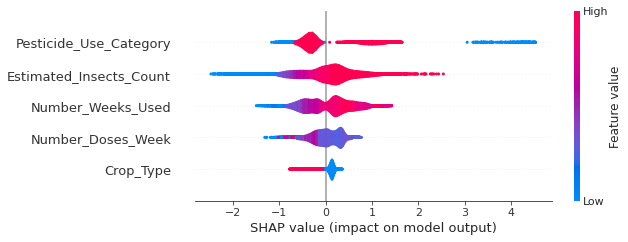

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(melhor_modelo_sem_boruta)

shap_values = explainer.shap_values(x_teste_sem_boruta_escalonado)

shap.summary_plot(shap_values[1], features=x_teste_sem_boruta_escalonado, feature_names=x_teste_sem_boruta.columns, plot_type="violin", show=False, max_display=5)


 ROC Curve para dados de **TESTE** sem o boruta

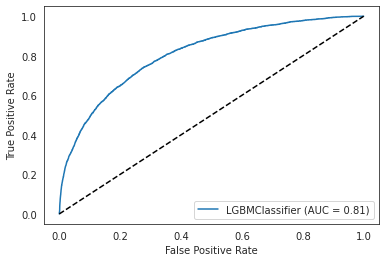

In [ ]:
from sklearn.metrics import plot_roc_curve

roc = plot_roc_curve(melhor_modelo_sem_boruta,x_teste_sem_boruta_escalonado,y_teste_sem_boruta)
plt.plot([0, 1], [0, 1], linestyle = '--',color = 'black')
plt.show()

 Precicion Recall Curve para dados de **TESTE** sem o boruta

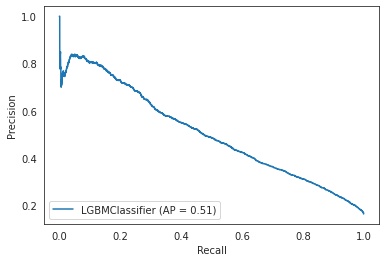

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

curve = plot_precision_recall_curve(melhor_modelo_sem_boruta,x_teste_sem_boruta_escalonado,y_teste_sem_boruta)
plt.show()

Curva de calibração para dados de **TESTE** sem o boruta

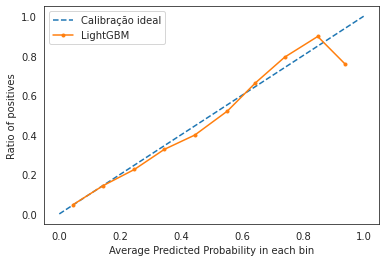

In [ ]:
from sklearn.calibration import calibration_curve

y_prob = melhor_modelo_sem_boruta.predict_proba(x_teste_sem_boruta_escalonado)

x, y = calibration_curve(y_teste_sem_boruta, y_prob[:, 1], n_bins = 10, normalize = True)
  
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Calibração ideal')
  
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'LightGBM')
  
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

Curva de densidade para dados de **TESTE** sem o boruta

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


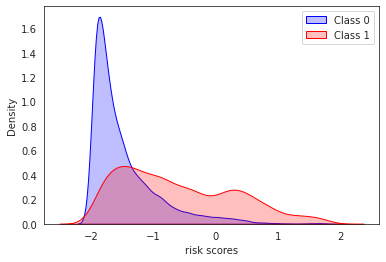

In [ ]:
import seaborn as sns

def remap(old_val, old_min, old_max, new_min, new_max):
    return (new_max - new_min)*(old_val - old_min) / (old_max - old_min) + new_min


sns.set_style("white")

model= melhor_modelo_sem_boruta

y_pred_pos = model.predict_proba(x_teste_sem_boruta_escalonado)[:, 1]

y_pred = model.predict(x_teste_sem_boruta_escalonado)

y_teste_sem_boruta = test_set['Crop_Damage'].copy()

res_0 = []
res_1 = []
for i, p in enumerate(y_pred_pos):
    if y_teste_sem_boruta.iloc[i] > 0:
        res_1.append(p)
    else:
        res_0.append(p)

normalized_res_0 = []
for i in res_0:
    normalized_res_0.append(remap(i, 0, 1, -2, 2))
normalized_res_1 = []
for i in res_1:
    normalized_res_1.append(remap(i, 0, 1, -2, 2))
sns.distplot(normalized_res_0, hist=False, kde_kws={"shade": True}, color='b', label='Class 0')
sns.distplot(normalized_res_1, hist=False, kde_kws={"shade": True}, color='r', label='Class 1')
plt.xlabel('risk scores')
plt.ylabel('Density')
plt.legend()
plt.show()